## Настройка библиотек

### pandas

Для его настройки достаточно просто сделать импорт.

Также добавим numpy и matplotlib - пригодится для быстрых преобразований данных и визуализаций.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### pyspark

PySpark прежде всего требует установки самого Spark и платформы Java. Установим свободный JDK (Java development kit) версии 8. А Apache Spark скачаем версии 3.5.0 с Hadoop.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

После этого в окружение среды нужно указать пути JAVA_HOME и SPARK_HOME на скачанные программы. Поскольку мы напрямую загрузили Spark, то он находится в директории content. Чтобы их добавить воспользуемся модулем os, который предоставляет интерфейс для взаимодействия с файловой системой.

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.5.0-bin-hadoop3"

Чтобы использовать PySpark как обычную Python-библиотеку, установим findspark, который сделает за нас остальную работу по инициализации.

In [3]:
!pip install findspark

Осталось инициализировать PySpark. Для этого вызывается метод findspark.init(), а дальше создаём точку входа кластера.

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession, functions
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Загрузка данных

Очень часто при анализе данных мы работаем с датасетами Kaggle — онлайн-площадки для соревнований по машинному обучению как в рамках конкурсов, так и для личных исследований. Обычно датасеты с Kaggle скачиваются напрямую на компьютер. Потом их загружают либо в Google Colab, либо в Google Drive. Причём если они загружаются с Drive, то придётся также их подгружать в Colab и вводить код доступа. Оба метода достаточно долгие, особенно если файлы большого размера. Поэтому загрузим файлы напрямую с Kaggle в Colab через Kaggle API.

Для этого, прежде всего необходимо создать аккаунт Kaggle (если у вас его еще нет). А затем в настройках аккаунта нужно создать API Token. Рисунок ниже показывает соответствующий раздел. После этого скачается файл kaggle.json, который содержит ваш личный код доступа.
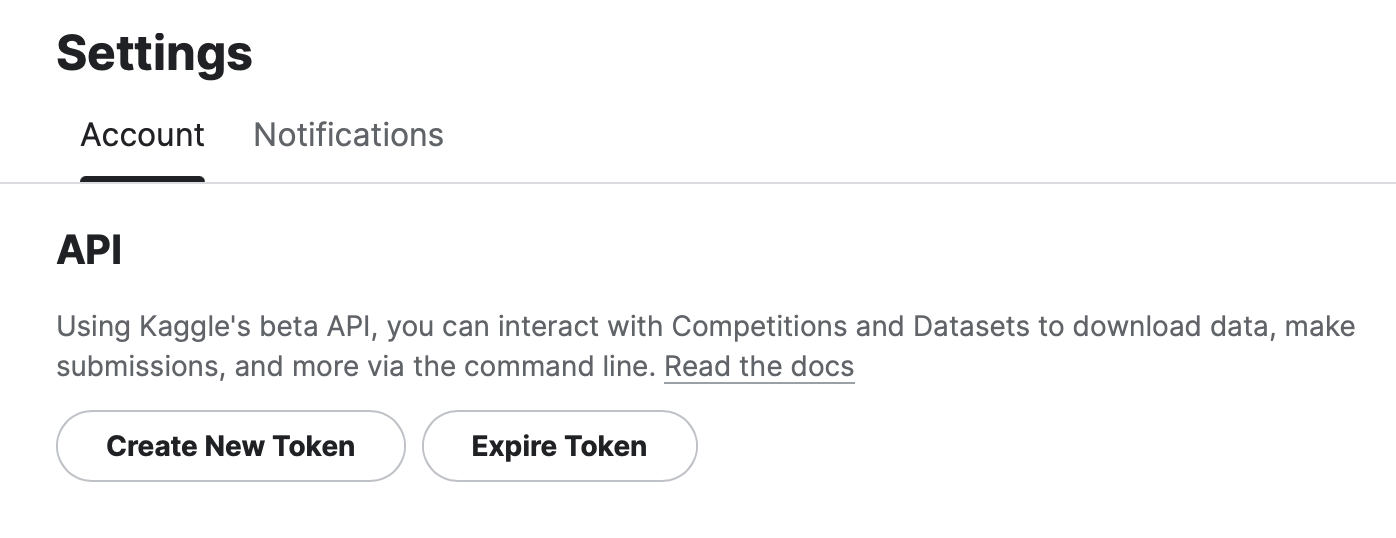

In [12]:
# !mkdir /root/.kaggle
# !touch /root/.kaggle/kaggle.json
!echo '{"username":"alexeyakulov","key":"13a773ea94aa434e23322891c65adc84"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

В этой и следующей практиках будем работать с [датасетом](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset), предназначенным для обучения алгоритма рекомендаций книг.

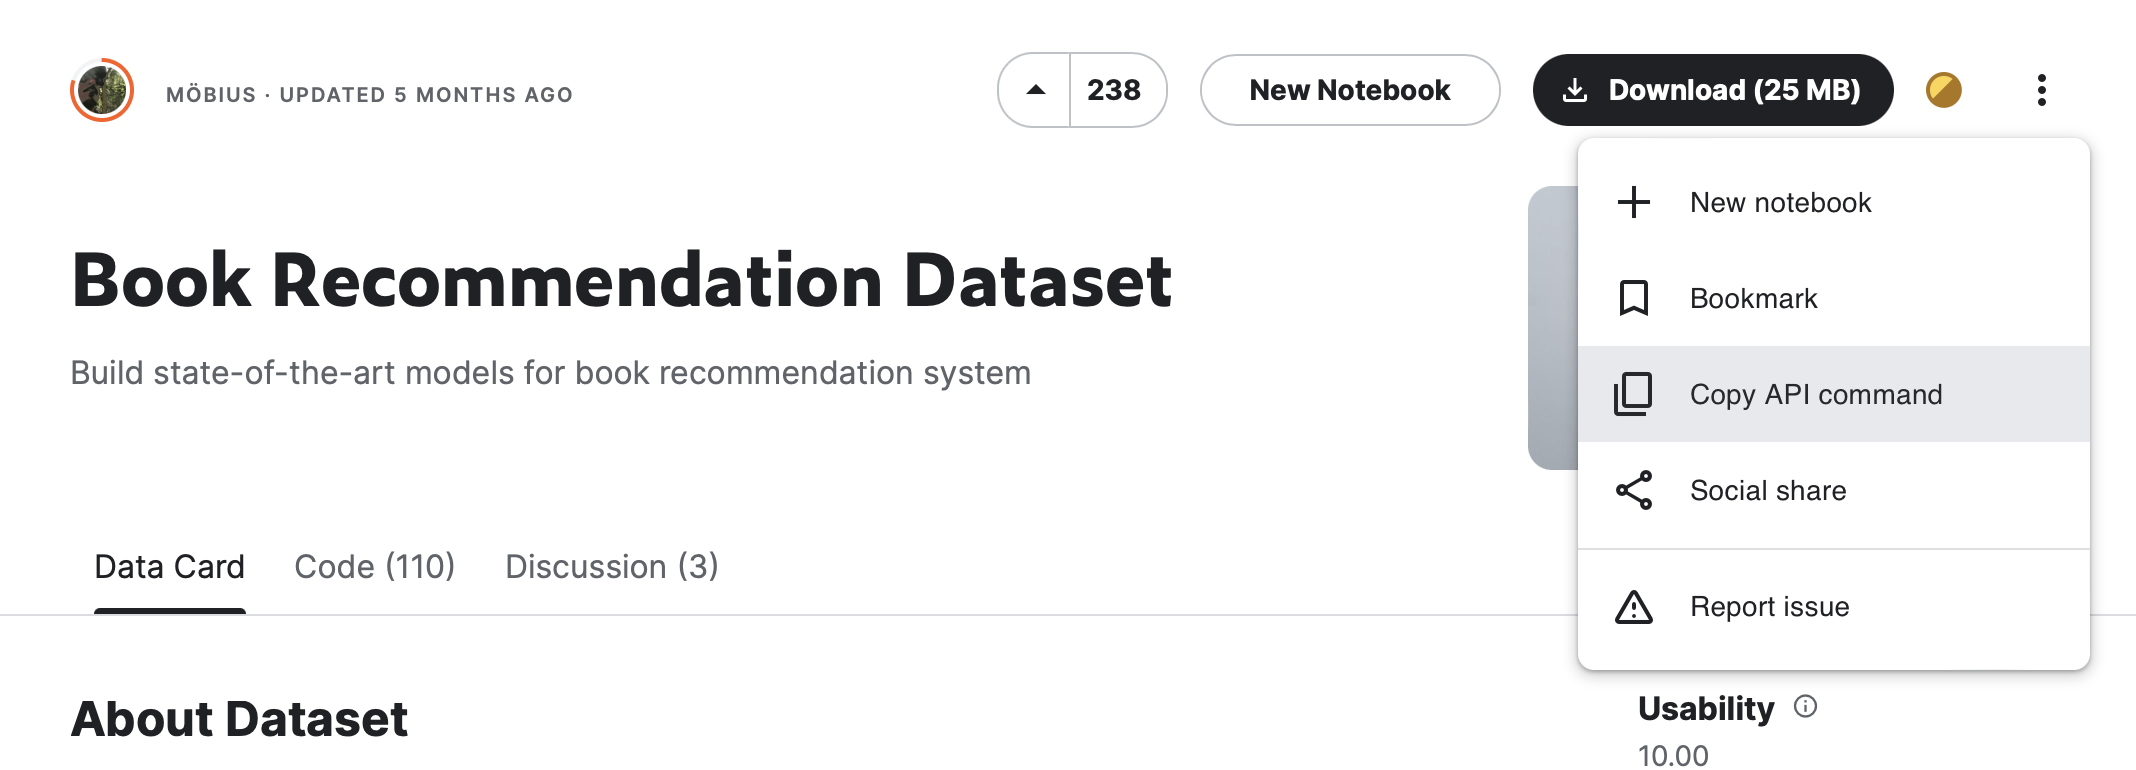

In [6]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

book-recommendation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip -q book-recommendation-dataset.zip

replace Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace recsys_taxonomy2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


## Упражнения с данными в pandas

### Подготовка

Загрузим данные и посмотрим на них: выведите по 3 первые строки каждого датафрейма с помощью метода  [head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html).

In [8]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

<ipython-input-8-84da3ecd6207>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


In [10]:
books["Year-Of-Publication"].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Посмотрим на размеры датафреймов.

In [46]:
books.shape, ratings.shape, users.shape

((271360, 8), (1149780, 3), (278858, 3))

Воспользуйтесь [функцией](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge) или [методом](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) merge, чтобы объединить три датафрейма в один.

In [47]:
df_books = books.merge(ratings, on='ISBN')
df_books = df_books.merge(users, on='User-ID')
df_books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN


В столбце Location указано достаточно много данных: город, регион, страна. Давайте разделим этот столбец на три с помощью метода [str.split()](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html) с параметром expand=True. Если в процессе у вас образовались лишние столбцы, удалите их методом [drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) с параметром inplace=True, чтобы не создавать новую таблицу. Это случилось потому, что со столбцом с локацией есть некоторые проблемы, но мы на них сейчас не будем обращать внимание.

In [ ]:
#put your code here
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,city,region,country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN,timmins,ontario,canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN,timmins,ontario,canada
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada",NaN,timmins,ontario,canada
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada",NaN,timmins,ontario,canada


Узнаем немного больше о книгах и пользователях.
1. Построим [гистограмму](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) распределения возрастов пользователей. Видно, что там есть отсутствующие значения. Будем их пока игнорировать.

In [ ]:
books.Age.describe()

count    753301.000000
mean         37.397648
std          14.098254
min           0.000000
25%          28.000000
50%          35.000000
75%          45.000000
max         244.000000
Name: Age, dtype: float64

Было бы неплохо не смотреть на то, что читают младенцы и мумии: посмотрим на возраст больше 0 и меньше 100. Для того, чтобы отсеять лишние строки, можно воспользоваться методом [query()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html).

В конце строки, отвечающей за вывод визуализации для вывода изображения без лишних указателей, можно поставить `;` или в следующей строке написать plt.show().

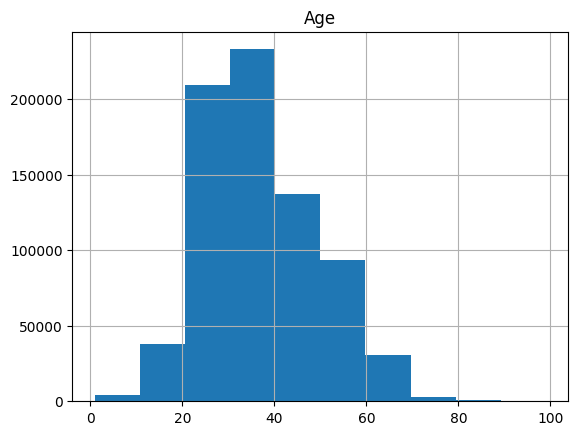

In [ ]:
#put_your_code_here

Какой можно сделать вывод о возрасте пользователей?

Для пользователей с возрастом больше 100 лет поставим значение возраста np.nan. Можно сделать это с помощью метода [apply()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html), например.

In [ ]:
#put your code here

2. Выясним, книги каких эпох представлены в датасете. Для этого построим еще диаграмму, теперь - с распределением кол-ва книг по годам.

In [ ]:
#put your code here

Вероятно, у вас возникла ошибка о невозможности сравнения строк и целых чисел. Посмотрите, нет ли чего несанкционированного в столбце с датой, например, выведя уникальные значения с помощью метода [unqiue()](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html).

In [ ]:
#put your code here

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1992, 1989, 1976, 1985, 1980, 1995, 1997, 1983, 1987, 1990,
       1982, 0, 1965, 1986, 1960, 1974, 1978, 1984, 1973, 1959, 1942,
       1979, 1972, 1981, 1957, 1971, 1963, 1958, 1966, 1930, 1969, 1953,
       1970, 1947, 1977, 1954, 1920, 1955, 1975, 1964, 1967, 2030, 2005,
       1951, 1927, 1961, 1968, 1962, 1948, 1925, 1923, '2002', '1994',
       '1970', '1990', '1998', '1991', '1989', '0', '2001', '1986',
       '1999', '2000', '1996', '1981', '1985', '1987', '1995', '2003',
       '1988', '1976', '1979', '1993', '1984', '1997', '1975', '1983',
       '1992', '1980', '1982', '2004', '1974', '1977', '1971', '1978',
       '1972', '1958', '1969', '1966', '1967', '1973', '1968', 1938, 1956,
       '1964', 1901, 1926, 1940, '1941', '1959', '1942', '1963', '1962',
       '1922', '1957', '1897', '1960', '1949', '1956', '1939', '1955',
       '1961', '1952', '1933', '1954', '1965', '1944', 1952, 2011, 

Часть чисел имеет вид строки - преобразовать не проблема. Но есть и две настоящих строки, на вид - названия издательств. Давайте посмотрим на строки с такими значениями.

In [ ]:
#put your code here

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,city,region,country
287500,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN,137190,0,"rennes, bretagne, france",31.0,rennes,bretagne,france
352361,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,227771,7,"savion, n/a, israel",19.0,savion,n/a,israel
467962,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN,130571,0,"summerville, south carolina, usa",NaN,summerville,south carolina,usa
469216,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN,169663,0,"towson, maryland, usa",NaN,towson,maryland,usa


В 4 строках некорректно открепили автора от названия. Для упрощения работы исключим эти строки из датасета.
>В качестве дополнительного упражнения верните порядок в эти строки с помощью pandas.

In [ ]:
#put your code here

Теперь продолжим с построением графика. Но сначала преобразуем весь столбец в целые числа с помощью метода [astype()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html).

In [ ]:
#put your code here

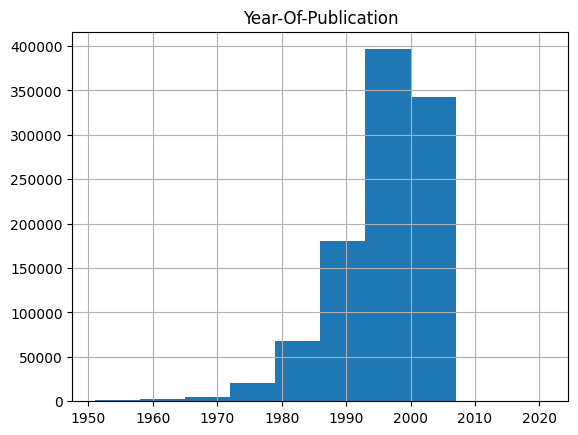

In [ ]:
#put your code here

3. Покажем на [столбчатой диаграмме](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html) топ-5 стран, в которых живут пользователи из датасета. Для этого понадобится сгруппировать столбец со страной методом [groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html). Не забудьте отсортировать столбцы ([sort_values()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)).

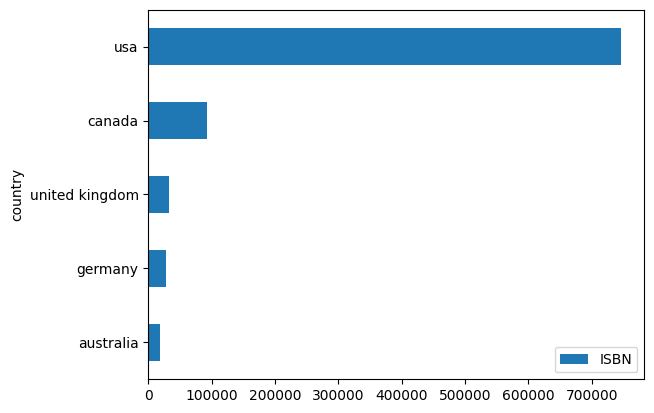

In [ ]:
#put your code here

### Упражнения

Теперь выполним несколько упражнений с данными.

1. Найдите книги, которые оценивали и жители России, и жители США. Посчитайте, жители какой страны в среднем ставили более высокие оценки одним и тем же книгам. Ретинг 0 не учитывайте.

In [ ]:
#put your code here

2. Найдите год, в который было выпущено наибольшее количество книг. И год, в который наименьшее. Выведите годы и количество выпущенных книг.

In [ ]:
#put your code here

## Упражнения с данными в pyspark

Повторим все те же действия, но с помощью PySpark.

### Подготовка

Загрузим данные и посмотрим на них. Метод show() зпускает выполнение операций, прописанных для датафрейма.

In [11]:
books = spark.read.option("header", True).csv("Books.csv")
ratings = spark.read.option("header", True).csv("Ratings.csv")
users = spark.read.option("header", True).csv("Users.csv")
books.show()
ratings.show()
users.show()

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari

Посмотрим на размеры датафреймов.

In [49]:
(books.count(), len(books.columns)), (ratings.count(), len(ratings.columns)), (users.count(), len(users.columns))

((271360, 8), (1149780, 3), (278859, 3))

Воспользуйтесь [функцией](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.join.html) join, чтобы объединить три датафрейма в один.

In [50]:
books_rating = books.join(ratings, on="ISBN", how="inner")
books_rating = books_rating.join(users, on="User-ID", how="inner")
books_rating.show()

+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+
|User-ID|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|Book-Rating|            Location| Age|
+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+
|   1000|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|          0|teramo, abruzzo, ...|34.0|
| 100004|0345339703|The Fellowship of...|      J.R.R. TOLKIEN|               1986|             Del Rey|http://images.ama...|http://images.ama...|http://images.ama...|         10|sa

In [51]:
(books_rating.count(), len(books_rating.columns))

(1031136, 12)

In [36]:
books_rating.show()

+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+
|User-ID|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|Book-Rating|            Location| Age|
+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+
|   1000|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|          0|teramo, abruzzo, ...|34.0|
| 100004|0345339703|The Fellowship of...|      J.R.R. TOLKIEN|               1986|             Del Rey|http://images.ama...|http://images.ama...|http://images.ama...|         10|sa

В столбце Location указано достаточно много данных: город, регион, страна. Давайте разделим этот столбец на три с помощью функции [split()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.split.html) и функции [withColumn()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.withColumn.html). Если в процессе у вас образовались лишние столбцы, удалите их методом [drop()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.drop.html). Это случилось потому, что со столбцом с локацией есть некоторые проблемы, но мы на них сейчас не будем обращать внимание.

In [37]:
from pyspark.sql.functions import split, col, desc, count, isnan

In [38]:
books_rating = (books_rating
                .withColumn("city", functions.split(books_rating["Location"], ",").getItem(0))
                .withColumn("region", functions.split(books_rating["Location"], ",").getItem(1))
                .withColumn("country", functions.split(books_rating["Location"], ",").getItem(2))
                .drop("Location", "CityCountry"))

In [39]:
books_rating.show()

+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+----+----------+-----------------+-------+
|User-ID|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|Book-Rating| Age|      city|           region|country|
+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+----+----------+-----------------+-------+
|   1000|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|          0|34.0|    teramo|          abruzzo|  italy|
| 100004|0345339703|The Fellowship of...|      J.R.R. TOLKIEN|               1986|             Del Rey|http://images

Узнаем немного больше о книгах и пользователях.
1. Построим [гистограмму](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) распределения возрастов пользователей. Видно, что там есть отсутствующие значения. Будем их пока игнорировать.

In [52]:
books_rating.select("Age").toPandas()["Age"].unique()

array(['37.0', '31.0', None, '32.0', '34.0', '70.0', '33.0', '48.0',
       '40.0', '28.0', '24.0', '22.0', '26.0', '36.0', '27.0', '46.0',
       '23.0', '42.0', '29.0', '25.0', '14.0', '68.0', '57.0', '51.0',
       '18.0', '35.0', '20.0', '56.0', '30.0', '49.0', '39.0', '47.0',
       '45.0', '21.0', '66.0', '62.0', '93.0', '38.0', '41.0', '58.0',
       '53.0', '201.0', '43.0', '72.0', '44.0', '64.0', '67.0', '17.0',
       '60.0', '54.0', '65.0', '13.0', '61.0', '15.0', '50.0', '11.0',
       '16.0', '8.0', '73.0', '52.0', '0.0', '55.0', '209.0', '63.0',
       '19.0', '9.0', '2.0', '76.0', '136.0', '59.0', '1.0', '74.0',
       '69.0', '71.0', '77.0', '81.0', '168.0', '151.0', '12.0', '104.0',
       '103.0', '7.0', ' norway"""', '85.0', '148.0', '10.0', '5.0',
       '239.0', '75.0', '78.0', '3.0', '83.0', '79.0', '101.0', '4.0',
       '84.0', '90.0', ' germany"""', ' thailand"""', ' sweden"""',
       '92.0', '97.0', '96.0', '82.0', ' spain"""', '80.0', '124.0',
       '141.0'

In [44]:
books.describe(["Age"]).show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            753333|
|   mean| 37.39758831409003|
| stddev|14.098294242258431|
|    min|      \""n/a\"""""|
|    max|              99.0|
+-------+------------------+



Для того, чтобы отсеять лишние строки, можно воспользоваться методом [filter()/where()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.filter.html).

Для сортировки можно воспользоваться методом [sort()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sort.html).

In [ ]:
books_rating = books_rating.filter(col("Age") < 100)

In [28]:
books_rating.sort(desc("Age")).show()

+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+
|User-ID|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|Book-Rating|            Location| Age|
+-------+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+----+
|   1000|8850200005|Il Dio Delle Picc...|       Arundhati Roy|               2002|     Distribooks Inc|http://images.ama...|http://images.ama...|http://images.ama...|          0|teramo, abruzzo, ...|34.0|
| 100004|0345339703|The Fellowship of...|      J.R.R. TOLKIEN|               1986|             Del Rey|http://images.ama...|http://images.ama...|http://images.ama...|         10|sa

Какой можно сделать вывод о возрасте пользователей?

2. Выясним, книги каких эпох представлены в датасете. Для этого построим еще диаграмму, теперь - с распределением кол-ва книг по годам.

In [ ]:
import matplotlib.pyplot as plt

age_distribution = books_rating.groupBy("Year-Of-Publication").agg(count("*").alias("Count"))
data = age_distribution.collect()

In [12]:
books.select("Year-Of-Publication").toPandas()["Year-Of-Publication"].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', ' and Anti-Environmental Violence"""',
       '1948', '1943', 'Cathy Thacker', '1947', '1945', '1923',
       'Henry David Thoreau', '2020', '1939', 'Donna Sterling', '1926',
       ' D.S.O.', '1938', '2030', 'Virginia Woolf', '1911', '1904',
       '1949', '1932', 'Ulrich Schmidt', '1928', '1929',
       'and the Final Ride of Jimmy Hoffa"""',
       ' and Musicians at Every Age from 1 to 100"""', '1

In [ ]:
ages = [row['Year-Of-Publication'] for row in data]
counts = [row['Count'] for row in data]
ages

['1953',
 '1957',
 '1897',
 '1987',
 '1956',
 '1936',
 '2020',
 '1958',
 '1943',
 '1972',
 '1931',
 ' and tasty! : combines all six smaller books!"""',
 ' and Musicians at Every Age from 1 to 100"""',
 ' and Box-Office Magic"""',
 '1988',
 '1911',
 '1926',
 '1938',
 '\\"" \\""Drachensteigen',
 '1932',
 '1977',
 '1971',
 '1984',
 ' D.S.O.',
 '1982',
 '1941',
 '2005',
 'Donna Sterling',
 ' samtaler med PÃ¤r Rittsel.] (Samtal)"""',
 '0',
 '2000',
 '1965',
 '1962',
 '1954',
 'Cathy Thacker',
 '2037',
 None,
 '1930',
 '1981',
 '1940',
 '1901',
 '1978',
 '1974',
 '2002',
 '1959',
 'Leslie Colitt',
 '1995',
 '1964',
 '1946',
 '2006',
 ' and \\""I\\"" Is for Innocent"""',
 '1921',
 '1976',
 '1942',
 '1935',
 '1947',
 ' 1961',
 '1967',
 '1968',
 '2004',
 '1989',
 '2011',
 '1939',
 '1992',
 '1961',
 '1966',
 'Jane Roberts',
 '1951',
 'Agatha Christie',
 'Inc. Staff Disney Enterprises',
 'Janet Kraegel',
 '1900',
 '1955',
 '1999',
 '1963',
 '1994',
 'Ulrich Schmidt',
 '1950',
 '1997',
 'David M. 

TypeError: ignored

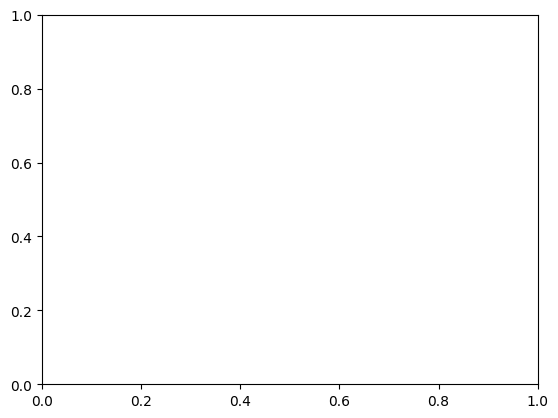

In [ ]:


ages = [row['Year-Of-Publication'] for row in data]
counts = [row['Count'] for row in data]

plt.bar(ages, counts)
plt.title("Age Distribution")
plt.xlabel("Year-Of-Publication")
plt.ylabel("Number of People")
plt.show()

Вероятно, у вас возникла ошибка о невозможности сравнения строк и целых чисел. Посмотрим на уникальные значения с помощью метода [distinct()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.distinct.html).

In [ ]:
#put your code here

В 4 строках некорректно открепили автора от названия. Для упрощения работы исключим эти строки из датасета.

In [ ]:
#put your code here

Теперь продолжим с построением графика. Но сначала преобразуем весь столбец в целые числа с помощью метода [cast()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.cast.html).

In [ ]:
#put your code here

3. Покажем на столбчатой диаграмме топ-5 стран, в которых живут пользователи из датасета. Для этого понадобится сгруппировать столбец со страной методом [groupBy()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html). Не забудьте отсортировать столбцы.

In [ ]:
#put your code here

### Упражнения

Теперь выполним несколько упражнений с данными.

1. Найдите книги, которые оценивали и жители России, и жители США. Посчитайте, жители какой страны в среднем ставили более высокие оценки одним и тем же книгам. Ретинг 0 не учитывайте.

In [ ]:
#put your code here

2. Найдите год, в который было выпущено наибольшее количество книг. И год, в который наименьшее. Выведите годы и количество выпущенных книг.

In [ ]:
#put your code here